<a href="https://colab.research.google.com/github/mikael-bashir/strange-attractors/blob/google-colab/strange-attractors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running on device: cuda
Step 5000/50000  |  Points counted: 250,000,000  |  Elapsed: 2.0s
Step 10000/50000  |  Points counted: 500,000,000  |  Elapsed: 3.9s
Step 15000/50000  |  Points counted: 750,000,000  |  Elapsed: 5.9s
Step 20000/50000  |  Points counted: 1,000,000,000  |  Elapsed: 7.9s
Step 25000/50000  |  Points counted: 1,250,000,000  |  Elapsed: 10.5s
Step 30000/50000  |  Points counted: 1,500,000,000  |  Elapsed: 12.4s
Step 35000/50000  |  Points counted: 1,750,000,000  |  Elapsed: 14.5s
Step 40000/50000  |  Points counted: 2,000,000,000  |  Elapsed: 16.5s
Step 45000/50000  |  Points counted: 2,250,000,000  |  Elapsed: 18.8s
Step 50000/50000  |  Points counted: 2,500,000,000  |  Elapsed: 21.4s


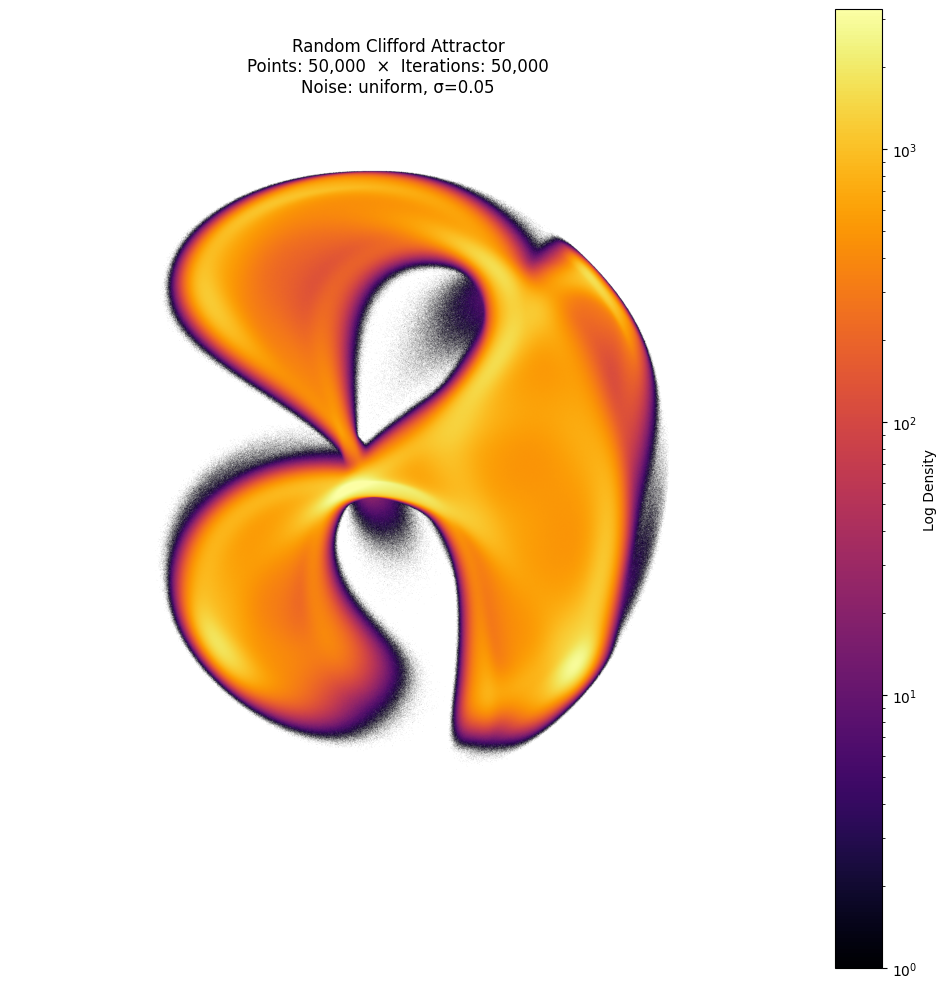

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time

# ─────────────────────────────────────────────────────────────────────────────
# CONFIGURATION
# ─────────────────────────────────────────────────────────────────────────────

# Number of iterations (time steps)
n_iter = 50_000

# Number of points (“trajectories”) to evolve in parallel
# Tune this up—e.g., 100 000 or 200 000—to saturate a T4’s 40 SMs.
n_points = 50_000

# Output image resolution
width, height = 4000, 4000

# Base parameters for the Clifford attractor (a, b, c, d). We'll add small noise each step.
base_params = torch.tensor([-1.4, 1.6, 1.0, 0.7], device='cuda')

# Range of x, y for scaling into pixel coordinates
x_min, x_max = -2.5, 2.5
y_min, y_max = -2.5, 2.5

# Noise settings
noise_type = 'uniform'    # 'uniform' | 'normal' | 'beta'
noise_level = 0.05     # Standard deviation (or half‐range for uniform/beta)

# Device check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on device: {device}")

# ─────────────────────────────────────────────────────────────────────────────
# HELPER FUNCTIONS
# ─────────────────────────────────────────────────────────────────────────────

def sample_noise(N, noise_type: str, noise_level: float):
    """
    Return a [N, 4] tensor of noise, depending on noise_type.
    """
    if noise_type == "uniform":
        # Uniform in [−1, +1] then scale
        return (torch.rand((N, 4), device=device) * 2 - 1) * noise_level

    elif noise_type == "normal":
        # Gaussian with mean 0, std = noise_level
        return torch.randn((N, 4), device=device) * noise_level

    else:  # "beta"
        # Beta(1,1) is uniform, but to illustrate: u/(u+v) ∈ [0,1], map to [−1,+1]
        u = torch.rand((N, 4), device=device)
        v = torch.rand((N, 4), device=device)
        beta_noise = u / (u + v)
        return (beta_noise * 2 - 1) * noise_level


def update_points(x, y, base_params, noise, x_min, x_max, y_min, y_max, width, height):
    """
    Given current x, y (each [N]), compute one Clifford‐step with noisy parameters,
    then return:
      - x_new, y_new    : updated coordinates [N]
      - flat_idx        : flat histogram indices [N] after scaling/clamping to [0..width−1]×[0..height−1]
    """
    # base_params: [4], noise: [N, 4] → params: [N, 4]
    params = base_params.unsqueeze(0) + noise
    a = params[:, 0]
    b = params[:, 1]
    c = params[:, 2]
    d = params[:, 3]

    # Clifford mapping (vectorized over N points):
    x_new = torch.sin(a * y) + c * torch.cos(a * x)
    y_new = torch.sin(b * x) + d * torch.cos(b * y)

    # Scale into pixel coordinates [0..width−1], [0..height−1]
    x_scaled = ((x_new - x_min) / (x_max - x_min) * (width - 1)).clamp(0, width - 1)
    y_scaled = ((y_new - y_min) / (y_max - y_min) * (height - 1)).clamp(0, height - 1)

    x_idx = x_scaled.long()
    y_idx = y_scaled.long()

    flat_idx = y_idx * width + x_idx  # [N]

    return x_new, y_new, flat_idx


def simulate_random_clifford(n_iter, n_points, base_params,
                             noise_type, noise_level,
                             width, height,
                             x_min, x_max, y_min, y_max):
    """
    Simulate a single Clifford attractor with time‐varying (noisy) parameters.
    Returns a [height, width] histogram (NumPy array) of visit counts.
    """
    # Allocate tensors on GPU
    x = torch.zeros(n_points, device=device, dtype=torch.float32)
    y = torch.zeros(n_points, device=device, dtype=torch.float32)

    # Flattened histogram vector of length W×H, type int32
    H = width * height
    hist = torch.zeros(H, device=device, dtype=torch.int32)

    # Warm‐up (discard transients)
    for _ in range(100):
        noise = sample_noise(n_points, noise_type, noise_level)
        x, y, _ = update_points(x, y, base_params, noise,
                                x_min, x_max, y_min, y_max, width, height)

    # Main loop
    start_time = time.time()
    for step in range(n_iter):
        # 1) Generate noise batch
        noise = sample_noise(n_points, noise_type, noise_level)

        # 2) Update all N points and get their new histogram indices
        x, y, flat_idx = update_points(x, y, base_params, noise,
                                       x_min, x_max, y_min, y_max, width, height)

        # 3) Increment histogram in one giant atomic operation
        #    histogram is a flat [H] vector; we add 1 for every index in flat_idx
        ones = torch.ones_like(flat_idx, dtype=torch.int32, device=device)
        hist.index_add_(0, flat_idx, ones)

        # 4) (Optional) Print progress every few thousand steps
        if (step + 1) % 5000 == 0:
            elapsed = time.time() - start_time
            total_pts = hist.sum().item()
            print(f"Step {step + 1}/{n_iter}  |  Points counted: {total_pts:,}  |  Elapsed: {elapsed:.1f}s")

    # Move histogram back to CPU and reshape
    hist_np = hist.cpu().numpy().reshape((height, width))
    return hist_np


# ─────────────────────────────────────────────────────────────────────────────
# RUN THE SIMULATION
# ─────────────────────────────────────────────────────────────────────────────

# WARNING: If n_points=100 000 and n_iter=100 000, this can take several minutes.
# You can reduce n_iter (e.g. to 50 000) or n_points (e.g. to 50 000) to test quickly.

hist = simulate_random_clifford(
    n_iter=n_iter,
    n_points=n_points,
    base_params=base_params,
    noise_type=noise_type,
    noise_level=noise_level,
    width=width,
    height=height,
    x_min=x_min,
    x_max=x_max,
    y_min=y_min,
    y_max=y_max,
)

# ─────────────────────────────────────────────────────────────────────────────
# VISUALIZE
# ─────────────────────────────────────────────────────────────────────────────

plt.figure(figsize=(10, 10), dpi=100)
# Transpose so that x‐axis is horizontal
plt.imshow(hist.T, origin='lower', cmap='inferno',
           norm=LogNorm(vmin=1, vmax=np.percentile(hist[hist > 0], 99.9)))
plt.colorbar(label='Log Density')
plt.title(f'Random Clifford Attractor\n'
          f'Points: {n_points:,}  ×  Iterations: {n_iter:,}\n'
          f'Noise: {noise_type}, σ={noise_level}')
plt.axis('off')
plt.tight_layout()
plt.show()
